# Clusterização

O Agrupamento ou Clustering faz parte das técnicas de Aprendizado de Máquina não Supervisionado.

Ele pode ser aplicado para diferentes problemas que envolvam **segmentação/agrupamento de dados**.

As técnicas de agrupamento apresentam a vantagem de não precisarem de dados rotulados (label).Nesse caso, queremos encontrar a label que não existe previamente sobre um conjunto de dados.

### Bibliotecas utilizadas

In [1]:
import pandas as pd

# Plot dos gráficos
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
import scipy.cluster.hierarchy as sch   # Dendograma

# Algoritmos de Agrupamento
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering #AgglomerativeClustering = Hierárquico
from sklearn.mixture import GaussianMixture

# Avaliacao de desemepnho

from sklearn.metrics import adjusted_rand_score, silhouette_score

# Algumas principais técnicas de clusterização

## Grupo de Consumidores

Esse conjunto de dados ilustra alguns dados dos consumidores de um shopping. 

**Será que podemos encontrar um certo padrão e criar grupos de consumidores com os dados?**

In [2]:
dados = pd.read_csv("Mall.csv", sep=',')

In [3]:
dados.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


### Analisando os dados
A seguir vamos analisar os tipos de dados que temos.

In [4]:
dados.shape

(200, 5)

## Limpeza dos dados

In [5]:
dados.isnull().sum()

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

## Análise exploratória dos dados

- Conhecer os dados, identificar padrões, encontrar anomalias, etc.

In [6]:
dados.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


In [7]:
dados['Annual Income (k$)'].mean()

60.56

In [8]:
dados['Annual Income (k$)'].median()

61.5

In [ ]:
dados['Annual Income (k$)'].std()

array([[<AxesSubplot:title={'center':'CustomerID'}>,
        <AxesSubplot:title={'center':'Age'}>],
       [<AxesSubplot:title={'center':'Annual Income (k$)'}>,
        <AxesSubplot:title={'center':'Spending Score (1-100)'}>]],
      dtype=object)

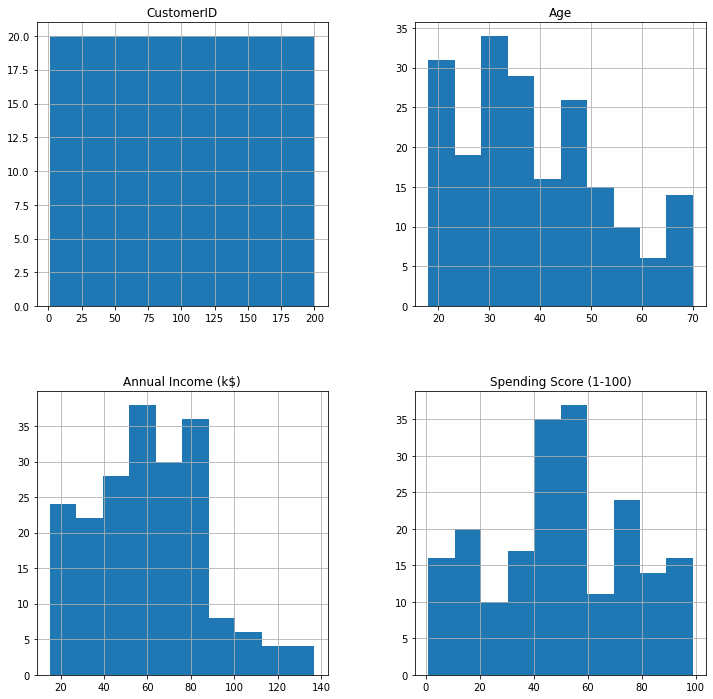

In [9]:
dados.hist(figsize=(12,12))

Analisando a correlação entre as variáveis:

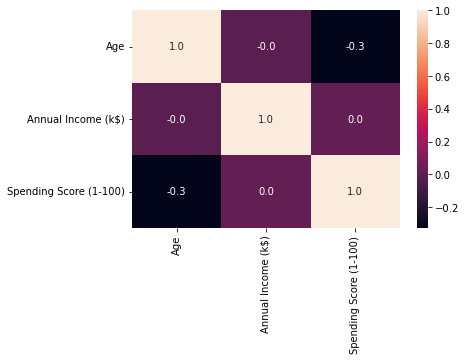

In [10]:
plt.figure(figsize=(6,4))
sns.heatmap(dados[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']].corr(method = 'pearson'), annot=True, fmt=".1f");

Analisando a proporção entre gêneros:

In [11]:
dados['Gender'].value_counts()

Female    112
Male       88
Name: Gender, dtype: int64

Boa proporção entre os generos que temos disponíveis em nossos dados.

Vamos fazer um gráfico completo com todos os dados para checarmos possíveis agrupamentos que podem ser realizados.

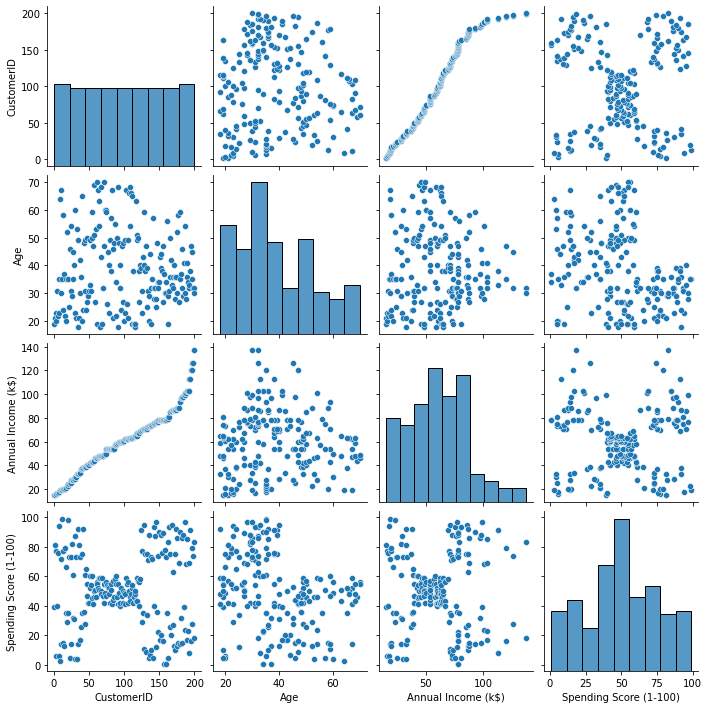

In [12]:
sns.pairplot(dados)
plt.show()

Aparentemente o Annual Income e o Spending Score permitem alguns agrupamentos dos nossos dados. 

Podemos trabalhar com eles.

## Feature Scaling

Verificar a necessidade de utilizar a padronização ou normalização dos dados

In [13]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler #Feature Engineer

In [14]:
#scaler = StandardScaler() 
scaler = MinMaxScaler() 
scaler.fit(dados[['Annual Income (k$)','Spending Score (1-100)']])

MinMaxScaler()

In [15]:
dados_Escalonados = scaler.transform(dados[['Annual Income (k$)','Spending Score (1-100)']])

In [16]:
dados_Escalonados

array([[0.        , 0.3877551 ],
       [0.        , 0.81632653],
       [0.00819672, 0.05102041],
       [0.00819672, 0.7755102 ],
       [0.01639344, 0.39795918],
       [0.01639344, 0.76530612],
       [0.02459016, 0.05102041],
       [0.02459016, 0.94897959],
       [0.03278689, 0.02040816],
       [0.03278689, 0.7244898 ],
       [0.03278689, 0.13265306],
       [0.03278689, 1.        ],
       [0.04098361, 0.14285714],
       [0.04098361, 0.7755102 ],
       [0.04098361, 0.12244898],
       [0.04098361, 0.79591837],
       [0.04918033, 0.34693878],
       [0.04918033, 0.66326531],
       [0.06557377, 0.28571429],
       [0.06557377, 0.98979592],
       [0.07377049, 0.34693878],
       [0.07377049, 0.73469388],
       [0.08196721, 0.04081633],
       [0.08196721, 0.73469388],
       [0.10655738, 0.13265306],
       [0.10655738, 0.82653061],
       [0.10655738, 0.31632653],
       [0.10655738, 0.6122449 ],
       [0.1147541 , 0.30612245],
       [0.1147541 , 0.87755102],
       [0.

### Criando os agrupamentos
Vamos criar agrupamentos com diferentes metodologias:

### 1 - K-Means

**Sobre o modelo:**
O K-Means parte da ideia de quebrar o espaço multidimensional de dados em partições a partir do centróide dos dados. Após inicializar os centróides de forma aleatória sobre os dados, o K-Means **calcula a distância dos dados para os centros mais próximos**. Esse cálculo da distância é realizado várias vezes até que os dados sejam agrupados da melhor forma possível de acordo com a distância mais próxima de um centróide (ponto centro de dado na qual será formado o grupo).

**Hiperparametros:**
Definição do K. Para definir esse valor de K, é necessário utilizar o **método Elbow** para encontrar o melhor hiperparâmetros de K. O método Elbow consiste no cálculo da soma dos erros quadráticos.

**Vantagens:**
Implementação simplificado e possui uma certa facilidade em lidar com qualquer medida de similaridade entre os dados.

**Desvantagem:**
Difícil definir o melhor K. Sensível a outliers. Não consegue distinguir grupos em dados não-globulares.

Para mais informação: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

Executando o algoritmo sem feature scaling

In [17]:
# Definindo o modelo de clusterizacao. K-MEANS com 6 clusters
kmeans = KMeans(n_clusters=6,random_state=0) #definindo os hiperparametros do algoritmo (definir o número de grupo = cluster)

#Implementando o K-Means nos dados:
kmeans.fit(dados[['Annual Income (k$)','Spending Score (1-100)']])

#Salvando os centroides de cada cluster
centroides = kmeans.cluster_centers_

#Salvando os labels dos clusters para cada exemplo
kmeans_labels = kmeans.predict(dados[['Annual Income (k$)','Spending Score (1-100)']])

Executando com feature scaling

In [18]:
# Definindo o modelo de clusterizacao. K-MEANS com 6 clusters
kmeans_escalonados = KMeans(n_clusters=6,random_state=0)

#Implementando o K-Means nos dados:
kmeans.fit(dados_Escalonados)

#Salvando os centroides de cada cluster
centroides_escalonados = kmeans.cluster_centers_

#Salvando os labels dos clusters para cada exemplo
kmeans_labels_escalonado = kmeans.predict(dados_Escalonados)

In [19]:
dados_Escalonados = pd.DataFrame(dados_Escalonados, columns = ['Annual Income (k$)','Spending Score (1-100)'])

In [20]:
dados_Escalonados.head()

,Annual Income (k$),Spending Score (1-100)
0,0.000000,0.387755
1,0.000000,0.816327
2,0.008197,0.051020
3,0.008197,0.775510
4,0.016393,0.397959


In [21]:
dados_Escalonados['Grupos'] = kmeans_labels_escalonado
dados_Escalonados.head()

,Annual Income (k$),Spending Score (1-100),Grupos
0,0.000000,0.387755,4
1,0.000000,0.816327,3
2,0.008197,0.051020,4
3,0.008197,0.775510,3
4,0.016393,0.397959,4


In [22]:
dados['Grupos'] = kmeans_labels
dados.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),Grupos
0,1,Male,19,15,39,4
1,2,Male,21,15,81,3
2,3,Female,20,16,6,4
3,4,Female,23,16,77,3
4,5,Female,31,17,40,4


Vamos analisar a nossa previsao e os centroides:

In [23]:
pd.Series(kmeans_labels).value_counts()

1    81
0    35
5    28
4    23
3    22
2    11
dtype: int64

In [24]:
centroides #espaço tridimensional (salário e score de gasto)

array([[ 88.2       ,  17.11428571],
       [ 55.2962963 ,  49.51851852],
       [108.18181818,  82.72727273],
       [ 25.72727273,  79.36363636],
       [ 26.30434783,  20.91304348],
       [ 78.03571429,  81.89285714]])

### Clusters com feature scaling

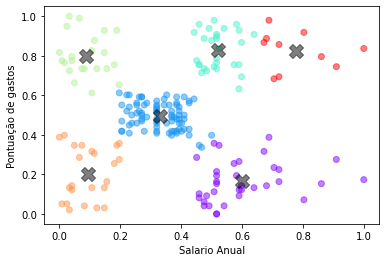

In [25]:
# plotando os dados identificando com os seus clusters
plt.scatter(dados_Escalonados[['Annual Income (k$)']],dados_Escalonados[['Spending Score (1-100)']], c=kmeans_labels_escalonado, alpha=0.5, cmap='rainbow')
plt.xlabel('Salario Anual')
plt.ylabel('Pontuação de gastos')

# plotando os centroides
plt.scatter(centroides_escalonados[:, 0], centroides_escalonados[:, 1], c='black', marker='X', s=200, alpha=0.5)
plt.rcParams['figure.figsize'] = (10, 5)
plt.show()

### Clusters sem feature scaling

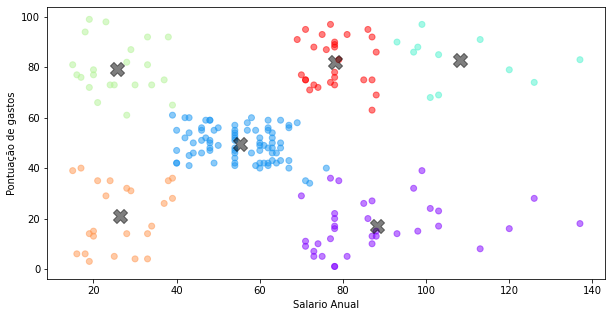

In [26]:
# plotando os dados identificando com os seus clusters
plt.scatter(dados[['Annual Income (k$)']],dados[['Spending Score (1-100)']], c=kmeans_labels, alpha=0.5, cmap='rainbow')
plt.xlabel('Salario Anual')
plt.ylabel('Pontuação de gastos')
# plotando os centroides
plt.scatter(centroides[:, 0], centroides[:, 1], c='black', marker='X', s=200, alpha=0.5)
plt.rcParams['figure.figsize'] = (10, 5)
plt.show()

Escolhendo a quantidade de grupos usando o método do "cotovelo":

In [27]:
# Lista com a quantidade de clusters que iremos testar
k = list(range(1, 10))
print(k)

[1, 2, 3, 4, 5, 6, 7, 8, 9]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


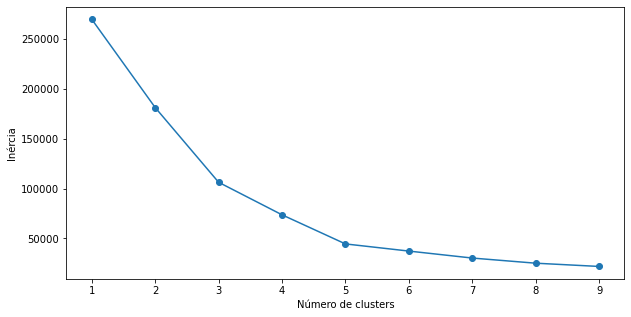

In [28]:
# Armazena o SSE (soma dos erros quadraticos) para cada quantidade de k
sse = []

# Roda o K-means para cada k fornecido
for i in k:
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(dados[['Annual Income (k$)','Spending Score (1-100)']])
    sse.append(kmeans.inertia_) #calculo do erro do k-mens (mudar o centroide dos dados)

plt.rcParams['figure.figsize'] = (10, 5)
# Plota o gráfico com a soma dos erros quadraticos
plt.plot(k, sse, '-o')
plt.xlabel(r'Número de clusters')
plt.ylabel('Inércia')
plt.show()

In [29]:
dados.groupby('Grupos')['Age'].mean()

Grupos
0    41.114286
1    42.716049
2    32.454545
3    25.272727
4    45.217391
5    32.785714
Name: Age, dtype: float64

In [30]:
dados.groupby('Grupos')['Annual Income (k$)'].mean()

Grupos
0     88.200000
1     55.296296
2    108.181818
3     25.727273
4     26.304348
5     78.035714
Name: Annual Income (k$), dtype: float64

Podemos notar que após 3 ou 5 clusters a soma do erro quadratico tem uma redução na forma com a qual a função está decrescendo. Assim podemos adotar 5 clusters. Checando os resultados para 5 clusters:

In [31]:
# Definindo o modelo de clusterizacao. K-MEANS com 5 clusters
kmeans = KMeans(n_clusters=5,random_state=0)

#Implementando o K-Means nos dados:
kmeans.fit(dados[['Annual Income (k$)','Spending Score (1-100)']])

#Salvando os centroides de cada cluster
centroides = kmeans.cluster_centers_

#Salvando os labels dos clusters para cada exemplo
kmeans_labels = kmeans.predict(dados[['Annual Income (k$)','Spending Score (1-100)']])

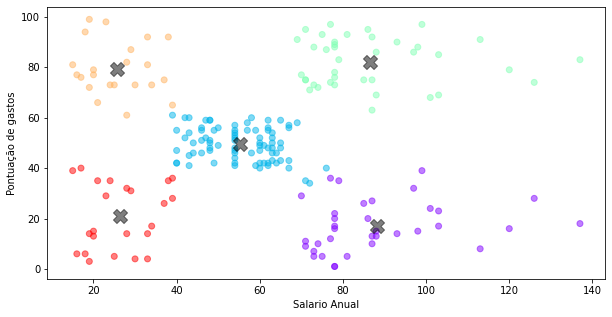

In [32]:
# plotando os dados identificando com os seus clusters
plt.scatter(dados[['Annual Income (k$)']],dados[['Spending Score (1-100)']], c=kmeans_labels, alpha=0.5, cmap='rainbow')
plt.xlabel('Salario Anual')
plt.ylabel('Pontuação de gastos')
# plotando os centroides
plt.scatter(centroides[:, 0], centroides[:, 1], c='black', marker='X', s=200, alpha=0.5)
plt.rcParams['figure.figsize'] = (10, 5)
plt.show()

In [33]:
dados_grupo_1 = dados[dados['Grupos'] == 1]
dados_grupo_1

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),Grupos
43,44,Female,31,39,61,1
46,47,Female,50,40,55,1
47,48,Female,27,40,47,1
48,49,Female,29,40,42,1
49,50,Female,31,40,42,1
...,...,...,...,...,...,...
121,122,Female,38,67,40,1
122,123,Female,40,69,58,1
126,127,Male,43,71,35,1
132,133,Female,25,72,34,1


In [ ]:
dados_grupo_2 = dados[dados['Grupos'] == 2]

In [ ]:
dados_grupo_3 = dados[dados['Grupos'] == 3]

In [ ]:
dados_grupo_4 = dados[dados['Grupos'] == 4]

In [ ]:
dados_grupo_1['Annual Income (k$)'].mean() #grupo 1 azul

In [ ]:
dados_grupo_2['Annual Income (k$)'].mean() #grupo 2 roxo

In [ ]:
dados_grupo_3['Annual Income (k$)'].mean() #grupo 3 laranja

In [ ]:
dados_grupo_3['Age'].mean()

In [ ]:
dados_grupo_2['Age'].mean() #grupo 2 roxo

In [ ]:
dados_grupo_4['Annual Income (k$)'].mean() #grupo 4 vermelho

In [ ]:
dados_grupo_3['Spending Score (1-100)'].mean() #grupo 4

In [ ]:
plt.figure(figsize=(6,4))
sns.heatmap(dados_grupo_1.groupby('Grupos').corr(method = 'pearson'), annot=True, fmt=".1f");

### 2 - DBSCAN

**Sobre o modelo:**
O DBSCAN é um algoritmo que agrupa os dados com base em **densidade (alta concentração de dados)**. Muito bom para tirar ruídos. O agrupamentos dos dados é calculado com base nos core (quantidade de pontos mínmos que seja igual ou maior a definição do MinPts), border (ponto de fronteira dos dados) e noise (ruído).

**Hiperparametro:**
Eps (raio ao redor de um dado). MinPts (mínimo de pontos dentro do raio para que seja agrupado).

**Vantagem:**
Capacidade de trabalhar com outliers. Trabalha com base de dados grande.

**Desvantagem:**
Dificuldade para lidar com cluster dentro de cluster. Dificuldade para lidar com dados de alta dimensionalidade. Dificuldade em encontrar o raio de vizinhança ao tentar agrupar dados com distância média muito distinta (clusters mais densos que outros).

Para mais informação: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html 

In [34]:
#Criando o modelo:
dbscan = DBSCAN(eps=10, min_samples=8)
#Ajustando aos dados
dbscan.fit(dados[['Annual Income (k$)','Spending Score (1-100)']])

dbscan_labels = dbscan.labels_
dbscan_labels


array([-1,  0,  1,  0, -1,  0,  1, -1,  1,  0, -1, -1, -1,  0,  1,  0, -1,
        0, -1, -1, -1,  0,  1,  0,  1,  0, -1, -1,  2,  0,  1,  0,  1, -1,
       -1,  0, -1,  0,  2, -1,  2, -1,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  3,  2,  3,  2,  3,  4,  3,  4,  3,  2,  3,  4,  3,
        4,  3,  4,  3,  4,  3,  2,  3,  4,  3,  2,  3,  4,  3,  4,  3,  4,
        3,  4,  3,  4,  3,  4,  3,  2,  3,  4,  3,  4,  3,  4,  3,  4, -1,
        4,  3,  4,  3,  4,  3,  4,  3,  4,  3, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1], dtype=int64)

Labels com -1 foram classificados como outliers

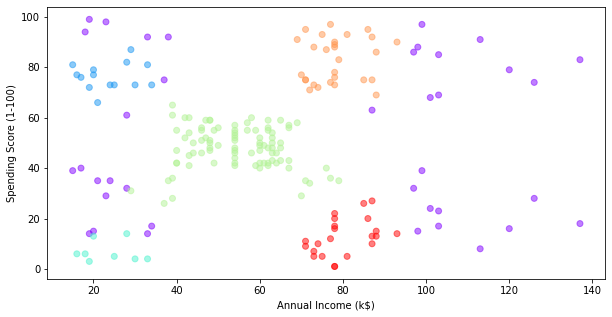

In [35]:
#Plotando o grafico:
plt.scatter(dados[['Annual Income (k$)']],dados[['Spending Score (1-100)']], c=dbscan_labels, alpha=0.5, cmap='rainbow')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.show()

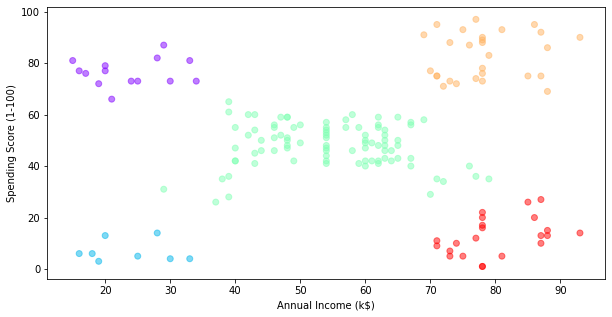

In [36]:
#Plotando o grafico sem os outliers:
#mascara para outlier
mascara = dbscan_labels>=0

#plotando o gráfico
plt.scatter(dados[['Annual Income (k$)']][mascara],dados[['Spending Score (1-100)']][mascara], c=dbscan_labels[mascara], alpha=0.5, cmap='rainbow')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.show()


Checando a quantidade de valores que foram classificados como Outliers:

In [37]:
list(mascara).count(False)

38

### 3 - Agrupamento Hierárquico

**Sobre o modelo:**
Agrupamento mede um limiar de similaridade entre os dados e cria hierarquias (ligações entre os grupos). Podemos visualizar grupos dentro de grupos. 

**Hiperparametros:**
O agrupamento é realizado com base em alguns tipos de critérios para realizar os ligamentos entre os dados (ward, average, complete, single).

**Vantagens:**
Implementação simplificada. Facilidade em lidar com qualquer medida de similaridade.

**Desvantagens:**
Dificuldade para encontrar qual dendograma melhor representa o grupo dos dados.  Sensível a outliers e ausência de normalização dos dados.

Para mais informação:https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html

In [38]:
# Criando o modelo
# linkage = ‘ward’ minimizes the variance of the clusters being merged.
model = AgglomerativeClustering(n_clusters=5,linkage='ward')

model.fit(dados[['Annual Income (k$)','Spending Score (1-100)']])
hierarquico_labels = model.labels_
hierarquico_labels

array([4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3,
       4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 1,
       4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 0, 2, 0, 2,
       1, 2, 0, 2, 0, 2, 0, 2, 0, 2, 1, 2, 0, 2, 1, 2, 0, 2, 0, 2, 0, 2,
       0, 2, 0, 2, 0, 2, 1, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2,
       0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2,
       0, 2], dtype=int64)

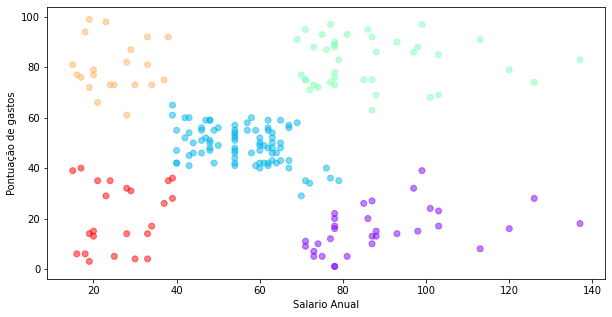

In [39]:
# plotando os dados identificando com os seus clusters
plt.scatter(dados[['Annual Income (k$)']],dados[['Spending Score (1-100)']], c=hierarquico_labels, alpha=0.5, cmap='rainbow')
plt.xlabel('Salario Anual')
plt.ylabel('Pontuação de gastos')
# plotando os centroides

plt.rcParams['figure.figsize'] = (15, 10)
plt.show()

Visualizando o dendrograma

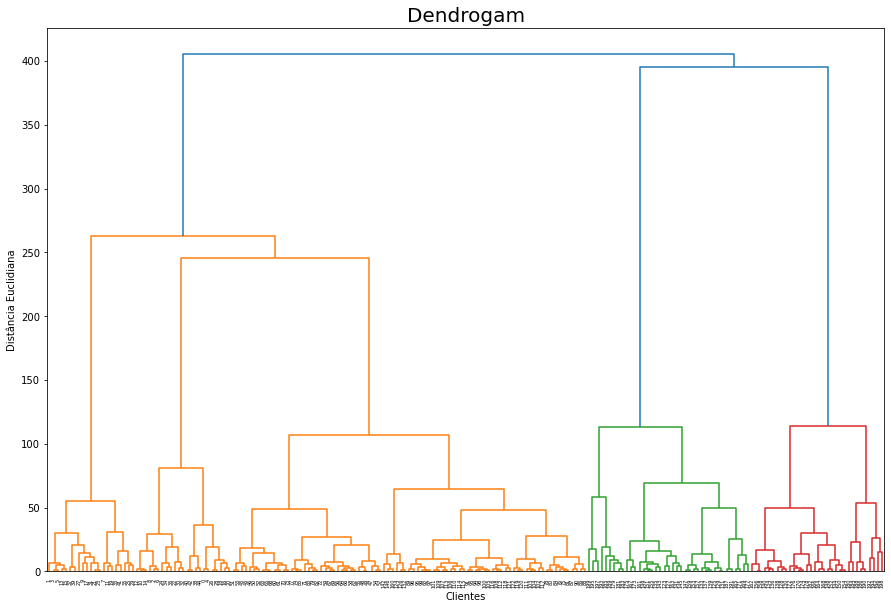

In [40]:
dendrogram = sch.dendrogram(sch.linkage(dados[['Annual Income (k$)','Spending Score (1-100)']], method = 'ward'))
plt.title('Dendrogam', fontsize = 20)
plt.xlabel('Clientes')
plt.ylabel('Distância Euclidiana')
plt.show()

## Como validar uma clusterização?

Temos dois tipos:
- Interna: Quanto bom foi o meu agrupamento?
- Externa: Como parecido estão os meus dois algoritmos comparados?

### Avaliando o Desempenho dos Algoritmos

### Tipo Externo:

(a) Usando o **Adjusted Rand Index**

Compara o desempenho quando forem fornecidos datasets com labels geradas de forma aleatória. Quando essas labels estão muito diferente, o valor se aproxima de 0, o que sugere um resultado negativo, ou seja, clusters não próximos.

Comparação entre K-Means e Agrupamento Hierarquico:

In [41]:
kmeans_labels

array([4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3,
       4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 1,
       4, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 0, 2, 1, 2, 0, 2, 0, 2,
       1, 2, 0, 2, 0, 2, 0, 2, 0, 2, 1, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2,
       0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2,
       0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2,
       0, 2])

In [42]:
hierarquico_labels

array([4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3,
       4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 1,
       4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 0, 2, 0, 2,
       1, 2, 0, 2, 0, 2, 0, 2, 0, 2, 1, 2, 0, 2, 1, 2, 0, 2, 0, 2, 0, 2,
       0, 2, 0, 2, 0, 2, 1, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2,
       0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2,
       0, 2], dtype=int64)

In [43]:
adjusted_rand_score(kmeans_labels,hierarquico_labels)

0.9419606318143182

Comparação entre K-Means e DBSCAN:

In [44]:
adjusted_rand_score(kmeans_labels,dbscan_labels)

0.7151933782093212

Comparação entre Agrupamento Hierarquico e o DBSCAN:

In [45]:
adjusted_rand_score(hierarquico_labels,dbscan_labels)

0.7753880543390358

Percebemos que o KMeans e o Agrupamento hierarquico para esse caso conseguiram resultados mais próximos um do outro do que quando comparados com o DBSCAN

#### Tipo interno:

(b) Avaliando a métrica de **Silhouette**

Mede o formato do cluster obtido: avalia a distância entre os centros dos clusters, nesse caso, queremos maximizar as distâncias)

Valores próximos a -1, significa clusters ruins, próximo a 1, clusters bem separados.

KMEANS:

In [46]:
silhouette_score(dados[['Annual Income (k$)','Spending Score (1-100)']],kmeans_labels)

0.553931997444648

DBSCAN:

In [47]:
silhouette_score(dados[['Annual Income (k$)','Spending Score (1-100)']],dbscan_labels)

0.36328873885121793

Agrupamento Hierarquico:

In [48]:
silhouette_score(dados[['Annual Income (k$)','Spending Score (1-100)']],hierarquico_labels)

0.5529945955148897